In [53]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.signal import lfilter

def Information_Transmit():
    M = 2 # bits per symbol (i.e. 2 in QPSK modulation)
    ## Information to transmit
    Info_to_TX='I worked all week on digital communications and all I got was this sequence of ones and zeros.'
    #Info_to_TX = 'A B'
    print('information to transmit:',Info_to_TX)
    
    # converts text string into binary
    binary = ''.join(format(ord(i), '07b') for i in Info_to_TX)
    print('binary equivalent:',binary)
    print('length of binary:', len(binary))
    # convert sequence of bits into an array
    data_bits = np.zeros((len(binary),))
    for i in range(len(binary)):
        data_bits[i] = binary[i]
    print('array equivalent:',data_bits)
    
    # Add synch_word
    sync_word = np.asarray([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0])
    print('sync_word:',sync_word)
    bit_sequence = np.hstack([sync_word, data_bits])
    
    # Add Preamble
    preamle_code = np.asarray([1,1,0,0])
    for i in range(16):
        if i ==0:
             preamble_swap = preamle_code
        else:    
            preamble = np.hstack([preamble_swap, preamle_code])
            preamble_swap = preamble
    
    print('preamble:',preamble)
    print('length of preamble:', len(preamble))
    QPSK_frame = np.hstack([preamble, bit_sequence])
    
    print('Transmit Frame length:',len(QPSK_frame))
    print('Transmit bit sequence:',QPSK_frame)
    # Convert serial data to parallel
    def Serial_to_Parallel(x):
        return x.reshape((len(x)//M, M))
    QPSK_bits = Serial_to_Parallel(QPSK_frame)

    print('QPSK signal to transmit[0:5]:\n',QPSK_bits[0:5])
    return QPSK_bits

In [490]:
Frame = Information_Transmit()
## Convert the binary into decimal 0,1,2,3
data1=[]
for i in range(len(Frame)):
    data1.append(2*Frame[i][0]+Frame[i][1])
Dec4_data = np.array(data1)
print('decimal number equivalent:',Dec4_data)

information to transmit: I worked all week on digital communications and all I got was this sequence of ones and zeros.
binary equivalent: 1001001010000011101111101111111001011010111100101110010001000001100001110110011011000100000111011111001011100101110101101000001101111110111001000001100100110100111001111101001111010011000011101100010000011000111101111110110111011011110101110111011010011100011110000111101001101001110111111011101110011010000011000011101110110010001000001100001110110011011000100000100100101000001100111110111111101000100000111011111000011110011010000011101001101000110100111100110100000111001111001011110001111010111001011101110110001111001010100000110111111001100100000110111111011101100101111001101000001100001110111011001000100000111101011001011110010110111111100110101110
length of binary: 658
array equivalent: [1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0.
 1. 1. 1. 0. 0. 

In [491]:
def lut(data, inputVec, outputVec):
    if len(inputVec) != len(outputVec):
        print('Input and Output vectors must have identical length')
    # Initialize output
    output = np.zeros(data.shape)
    # For each possible data value
    eps = np.finfo('float').eps
    for i in range(len(inputVec)):
        # Find the indices where data is equal to that input value
        for k in range(len(data)):
            if abs(data[k]-inputVec[i]) < eps:
                # Set those indices in the output to be the appropriate output value.
                output[k] = outputVec[i]
    return output

In [492]:
def oversample(x, OS_Rate):
    # Initialize output
    length = len(x[0])
    x_s = np.zeros((1,length*OS_Rate))
    # Fill in one out of every OS_Rate samples with the input values
    count = 0
    h = 0
    for k in range(len(x_s[0])):
        count = count + 1
        if count == OS_Rate:
            x_s[0][k] = x[0][h]
            count = 0
            h = h + 1
    return x_s

In [493]:
def SRRC(alpha, N, Lp):
    # Add epsilon to the n values to avoid numerical problems
    ntemp = list(range(-N*Lp, N*Lp+1))
    n = []
    for each in ntemp:
        n.append(each + math.pow(10,-9))
    # Plug into time domain formula for the SRRC pulse shape
    h = []
    coeff = 1/math.sqrt(N)
    for each in n:
        sine_term = math.sin(math.pi * each * (1-alpha) / N)
        cosine_term = math.cos(math.pi * each * (1+alpha) / N)
        cosine_coeff = 4 * alpha * each / N
        numerator = sine_term + (cosine_coeff * cosine_term)
        denom_coeff = math.pi * each / N
        denom_part = 1 - math.pow(cosine_coeff, 2)
        denominator = denom_coeff * denom_part
        pulse = coeff * numerator / denominator
        h.append(pulse)
    return h

In [494]:
###########################################
### Modulation
### INPUT: data
### OUTPUT: modulated values, x

A = math.sqrt(9/2)
inputVec   = [0, 1, 2, 3]
outputVecI = [A, -A, A, -A]
outputVecQ = [A, A, -A, -A]
xI         = lut(Dec4_data, inputVec, outputVecI)
xQ         = lut(Dec4_data, inputVec, outputVecQ)
xI = xI.reshape((1,len(Dec4_data)))
xQ = xQ.reshape((1,len(Dec4_data)))

In [495]:
###########################################
### Upsample
### INPUT: modulated values, x
### OUTPUT: modulated values at sampling rate, x_s

x_s_I = oversample(xI,8)
x_s_Q = oversample(xQ,8)

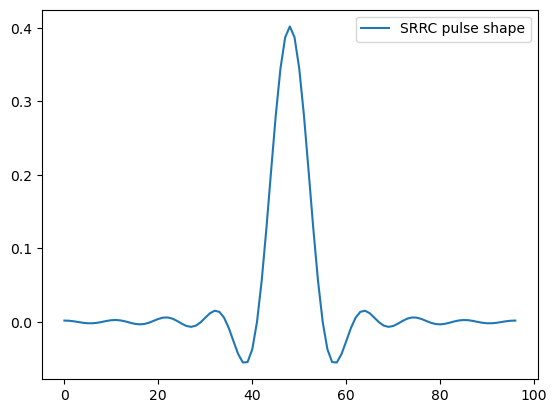

In [496]:
pulse = SRRC(0.5, 8, 6)
pulse = np.array(pulse)
pulse = np.reshape(pulse, pulse.size)
plt.figure()
plt.plot(pulse,label='SRRC pulse shape')
plt.legend()

x_s_I = np.reshape(x_s_I, x_s_I.size)
x_s_Q = np.reshape(x_s_Q, x_s_Q.size)
s_0_I = np.convolve(x_s_I, pulse, mode='full')
s_0_Q = np.convolve(x_s_Q, pulse, mode='full')



In [497]:
# create complex IQ value from the I and Q components
QPSK_samples = s_0_I + s_0_Q*1j

print('QPSK_samples[0:10]:',QPSK_samples[0:10])

QPSK_samples[0:10]: [ 0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j         -0.00333891-0.00333891j -0.00283863-0.00283863j
 -0.00127108-0.00127108j]


QPSK_samples_Final[1020:1040] [ 0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j         -0.00333891-0.00333891j
 -0.00283863-0.00283863j -0.00127108-0.00127108j  0.00092964+0.00092964j
  0.00306926+0.00306926j  0.00441   +0.00441j     0.00442226+0.00442226j
  0.00298813+0.00298813j  0.0038212 +0.0038212j ]


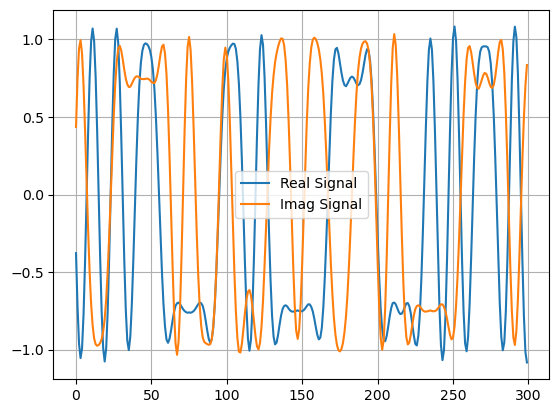

In [498]:
## Add 1024 zero value samples at the beginning
## Zeros are added to compensate for samples lost during initialization at the receiver
QPSK_samples_Final = np.hstack([np.zeros(1024, dtype=type(QPSK_samples[0])),QPSK_samples])

plt.figure()
plt.plot(np.real(QPSK_samples_Final[1700:2000]),label='Real Signal')
plt.plot(np.imag(QPSK_samples_Final[1700:2000]),label='Imag Signal')
plt.grid('on')
plt.legend()
print('QPSK_samples_Final[1020:1040]',QPSK_samples_Final[1020:1040])

In [499]:
def write_complex_binary(data, filename):
    '''
    Open filename and write array to it as binary
    Format is interleaved float IQ e.g. each I,Q should be 32-bit float 
    INPUT
    ----
    data:     data to be wrote into the file. format: (length, )
    filename: file name
    '''
    re = np.real(data)
    im = np.imag(data)
    binary = np.zeros(len(data)*2, dtype=np.float32)
    binary[::2] = re
    binary[1::2] = im
    binary.tofile(filename)   
write_complex_binary(QPSK_samples_Final, 'QPSK_signal.iq')

In [500]:
def get_samps_from_file(filename): 
    '''
    load samples from the binary file
    '''
    # File should be in GNURadio's format, i.e., interleaved I/Q samples as float32
    samples = np.fromfile(filename, dtype=np.float32)
    samps = (samples[::2] + 1j*samples[1::2]).astype((np.complex64)) # convert to IQIQIQ  
    return samps

In [501]:
get_samps_from_file('QPSK_signal.iq')[1020:1040]

array([ 0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        , -0.00333891-0.00333891j,
       -0.00283863-0.00283863j, -0.00127108-0.00127108j,
        0.00092964+0.00092964j,  0.00306926+0.00306926j,
        0.00441   +0.00441j   ,  0.00442226+0.00442226j,
        0.00298813+0.00298813j,  0.0038212 +0.0038212j ], dtype=complex64)